In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2'
data_file = '/data/B2/data.mat'
epoch_file = '/data/B2/preprocessing/B2_EEG_epo.fif'


relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']

# Dic to index trial_info matrix
info_colnames = {'reaction_times':0,'reaction_err':1, 'answer':2,'base_delay':3,\
                      'target_timings':4, 'flicker_sides':5, 'cued_side':6, 'orients_L':7, 'orients_R':8,\
                      'angle_magnitude':9, 'probe_sides':10, 'targets_binary':12, 'attention_type_block':13,\
                      'trial_num_my_rec':14}
info_colnumtonames = {v: k for k, v in info_colnames.items()}




In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy
from collections import Counter
from frequency_tagging_funs import snr_spectrum, ssvep_amplitudes, coherence_kabir, model_training


f = sio.loadmat(f'{data_path}{data_file}')

# Create pd df to pass to mne metadata
pd_info = {}
for i, column in enumerate(f['data'][0][0]):
    if i in info_colnames.values():
        # Remove practice trials
        column = column[4:,:]
        # Collapse to trial indexes
        original_shape = column.shape
        new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
        column = np.reshape(column, new_shape)
        pd_info[info_colnumtonames[i]] = column
pd_info = pd.DataFrame(pd_info, columns=info_colnames.keys())
pd_info 

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epoch_good = [x for x,y in enumerate(epochs.drop_log) if len(y) == 0]
epochs.metadata = pd_info.iloc[epoch_good]

Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B2/preprocessing/B2_EEG_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
555 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 14 columns


In [3]:
# Keep only trials where there was no target
epochs = epochs['targets_binary==0']
#Only keep EEG channels
epochs = epochs.pick_types(eeg=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


# A. Endogeneous condition
## 1 FFT & SNR

In [4]:


# Simplify metadata
epochs.metadata['flicker_sides'] = epochs.metadata['flicker_sides'].replace({0: 6064, 1: 6460})
epochs.metadata['cued_side'] = epochs.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'left')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'right'))
condition_2 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'right')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'left'))
epochs.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 64, np.nan))
epochs_endo = epochs['attention_type_block==1'].copy()
epochs_exo = epochs['attention_type_block==0'].copy()

/tmp/ipykernel_63308/2690054239.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


SNR at 60Hz in endogenous condition: 23.972663825126535
SNR at 64Hz in endogenous: 18.12227311118051
SNR at 60Hz in exogenous condition: 18.562632680435186
SNR at 64Hz in exogenous: 16.930903735299076


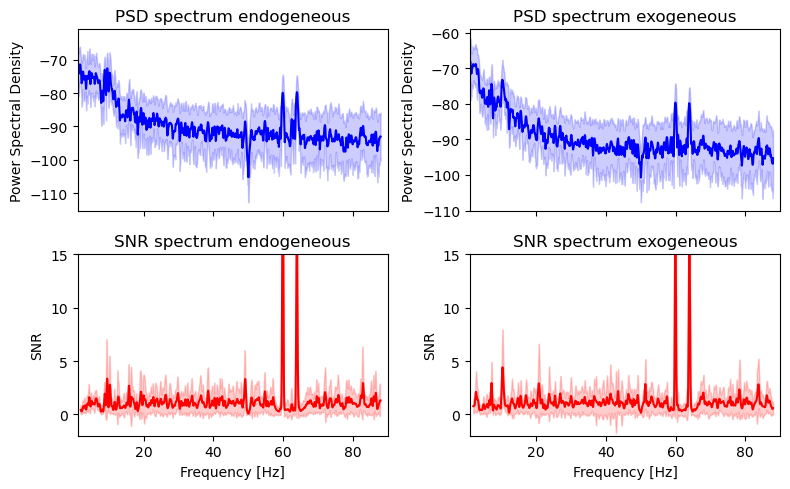

In [5]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

sfreq = epochs.info["sfreq"]
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90

# Spectrum of the signal averaged over trials
freqs_psd, psds_endo = ssvep_amplitudes(epochs_endo, epochs.info['ch_names'], tmin, tmax)
freqs_psd, psds_exo = ssvep_amplitudes(epochs_exo, epochs.info['ch_names'], tmin, tmax)

# Get bins to exlude from regularization (close neighbors ±0.5Hz)  
bin_size = np.diff(freqs_psd)[0]
skip_nei = int((0.5 - bin_size/2)//bin_size) 

# Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]

snrs_endo = snr_spectrum(psds_endo, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)
snrs_exo = snr_spectrum(psds_exo, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)

fig, axes = plt.subplots(2, 2, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_psd) == 1.0)[0][0], np.where(np.ceil(freqs_psd) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds_endo)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0,0].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0,0].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0,0].set(title="PSD spectrum endogeneous", ylabel="Power Spectral Density")

psds_plot = 10 * np.log10(psds_exo)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0,1].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0,1].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0,1].set(title="PSD spectrum exogeneous", ylabel="Power Spectral Density")

# SNR spectrum
snr_mean = snrs_endo.mean(axis=(0))[freq_range]
snr_std = snrs_endo.std(axis=(0))[freq_range]

axes[1,0].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1,0].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1,0].set(
    title="SNR spectrum endogeneous",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 15],
    xlim=[fmin, fmax],
)
snr_mean = snrs_exo.mean(axis=(0))[freq_range]
snr_std = snrs_exo.std(axis=(0))[freq_range]

axes[1,1].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1,1].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1,1].set(
    title="SNR spectrum exogeneous",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 15],
    xlim=[fmin, fmax],
)
plt.tight_layout()
fig.show()

# Extract SNR values at the stimulation frequency
stim_freq1 = 60
stim_freq2 = 64

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

# Apply the subset
snrs_target1_endo = snrs_endo[:, i_bin_1]
snrs_target2_endo = snrs_endo[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz in endogenous condition: {snrs_target1_endo.mean()}')
print(f'SNR at {stim_freq2}Hz in endogenous: {snrs_target2_endo.mean()}')
snrs_target1_exo = snrs_exo[:, i_bin_1]
snrs_target2_exo = snrs_exo[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz in exogenous condition: {snrs_target1_exo.mean()}')
print(f'SNR at {stim_freq2}Hz in exogenous: {snrs_target2_exo.mean()}')


## 1.2 Topography of the SNR

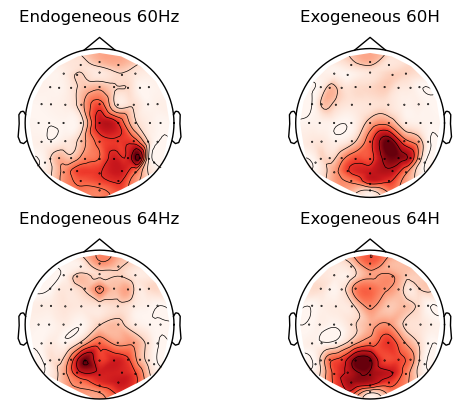

Channels with highest SNR for 60Hz endo ['P6' 'Cz' 'PO4' 'P2']
Channels with highest SNR for 64Hz endo ['CP2' 'P4' 'P2' 'PO4']
Channels with highest SNR for 60Hz exo ['P1' 'O2' 'POz' 'P2']
Channels with highest SNR for 64Hz exo ['P1' 'Pz' 'POz' 'O1']


In [6]:
# plot SNR topography
fig, ax = plt.subplots(2,2)
mne.viz.plot_topomap(snrs_target1_endo, epochs.info, vlim=(1, None), axes=ax[0,0], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target2_endo, epochs.info, vlim=(1, None), axes=ax[0,1], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target1_exo, epochs.info, vlim=(1, None), axes=ax[1,0], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target2_exo, epochs.info, vlim=(1, None), axes=ax[1,1], show=False, extrapolate='local')
ax[0,0].set_title('Endogeneous 60Hz')
ax[0,1].set_title('Exogeneous 60H')
ax[1,0].set_title('Endogeneous 64Hz')
ax[1,1].set_title('Exogeneous 64H')
plt.show()

# Channels with the highest SNR 
print(f'Channels with highest SNR for 60Hz endo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:4]}')
print(f'Channels with highest SNR for 64Hz endo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:4]}')
print(f'Channels with highest SNR for 60Hz exo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_exo)[::-1]][:4]}')
print(f'Channels with highest SNR for 64Hz exo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_exo)[::-1]][:4]}')
#select electrodes from 60 as the top electrodes are parietal and occipital
SNR_best_electrodes_60_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:4]
SNR_best_electrodes_64_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:4]
SNR_best_electrodes_60_exo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_exo)[::-1]][:4]
SNR_best_electrodes_64_exo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_exo)[::-1]][:4]

## 1.3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and up to the stimulus offset.

### Inter-trial coherence with Morlet estimation

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   13.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   15.9s


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


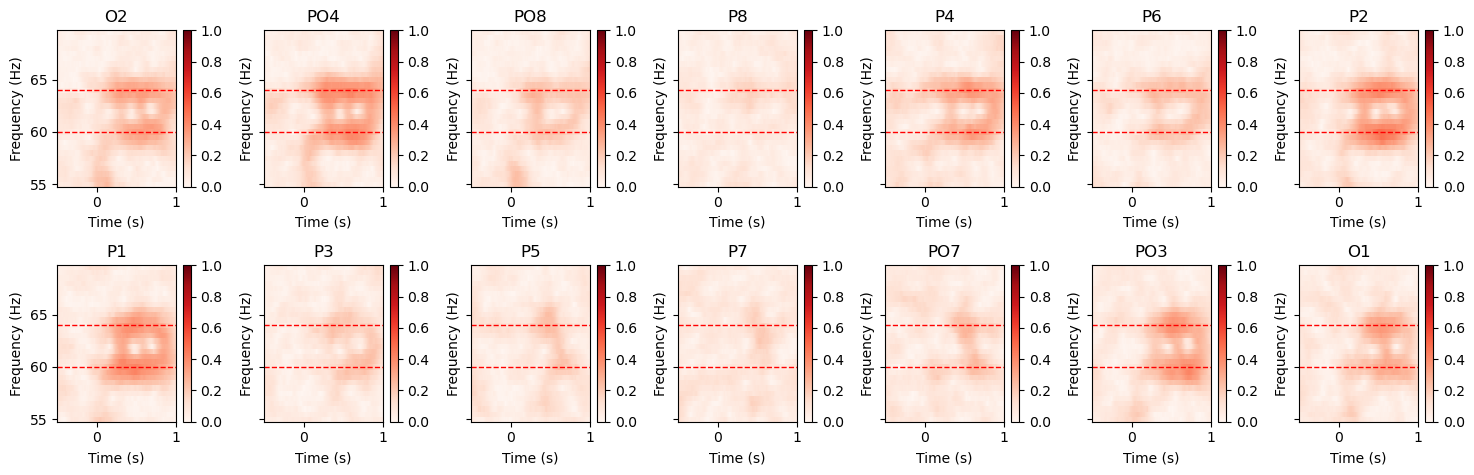

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


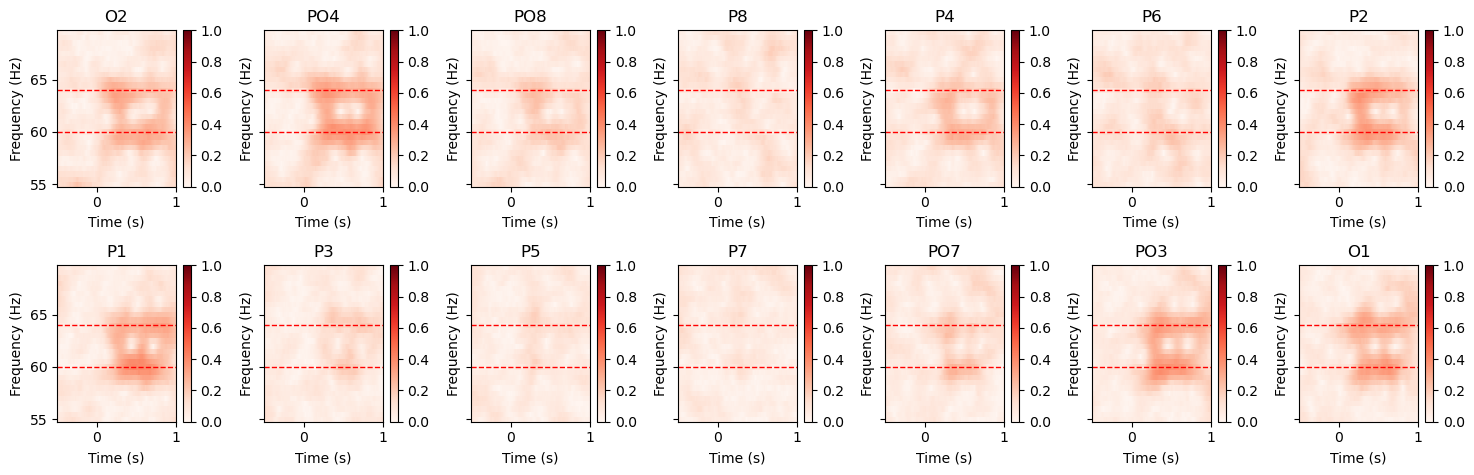

In [7]:
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized by picking the maximum number of cycles to have the wavelets slightly shorter than the signal.


# time window from -.5 sec to 1 sec relative to cue
tmin, tmax = -.5, 1
# Define range of frequencies of interest +/- 5 to the tagged frequencies
freqs = np.arange(55, 70, step = 0.5)

_, power_endo = epochs_endo.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs-10, return_itc=True, average=True
)
_, power_exo = epochs_exo.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs-10, return_itc=True, average=True
)


fig, axes = plt.subplots(2, 7, figsize=(15, 5), sharey = True) 
axes = axes.flatten() 

channels = relevant_electrodes#Just plot in relevant electrodes to make it easier

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    power_endo.plot(
        picks=[channel],
        baseline=None,
        vlim=(0,1),
        axes=ax,
        colorbar=True,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(2, 7, figsize=(15, 5), sharey = True) 
axes = axes.flatten() 

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    power_exo.plot(
        picks=[channel],
        baseline=None,
        vlim=(0,1),
        axes=ax,
        colorbar=True,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

In [8]:
# Check whether the expected frequencies are indeed the highest
power_arr, frex_idx = power_endo.get_data(return_freqs=True)
print(f'Frequencies in endogeneous with the maximum coherence in descending order : {frex_idx[power_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')
print(f'From best to 4th \nChannels with the highest coherence with 64 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(power_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:4]} \
                        \nChannels with the highest coherence with 60 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(power_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:4]}')
best_electrodes_coherence_morlet_60_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(power_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:4]
best_electrodes_coherence_morlet_64_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(power_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:4]

power_arr, frex_idx = power_exo.get_data(return_freqs=True)
print(f'Frequencies in exogeneous with the maximum coherence in descending order : {frex_idx[power_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')
print(f'From best to 4th \nChannels with the highest coherence with 64 in exo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(power_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:4]} \
                        \nChannels with the highest coherence with 60 in enxxo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(power_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:4]}')
best_electrodes_coherence_morlet_60_exo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(power_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:4]
best_electrodes_coherence_morlet_64_exo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(power_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:4]

Frequencies in endogeneous with the maximum coherence in descending order : [63.5 64.  60.  59.5]
From best to 4th 
Channels with the highest coherence with 64 in endo:['P2' 'POz' 'Pz' 'P1']                         
Channels with the highest coherence with 60 in endo:['POz' 'PO4' 'P2' 'Pz']
Frequencies in exogeneous with the maximum coherence in descending order : [64.  60.  63.5 59.5]
From best to 4th 
Channels with the highest coherence with 64 in exo:['Pz' 'POz' 'P1' 'PO3']                         
Channels with the highest coherence with 60 in enxxo:['POz' 'PO4' 'PO3' 'P2']


## 1.4 Select electrodes based on previous analysis

In [9]:
print(f'Top 4 electrodes for SNR 60 endo {SNR_best_electrodes_60_endo}')
print(f'Top 4 electrodes for SNR 64 endo {SNR_best_electrodes_64_endo}')
print(f'Top 4 electrodes for SNR 60 exo {SNR_best_electrodes_60_exo}')
print(f'Top 4 electrodes for SNR 64 exo {SNR_best_electrodes_64_exo}')
print(f'Top 4 electrodes for ITC morlet 60 endo {best_electrodes_coherence_morlet_60_endo}')
print(f'Top 4 electrodes for ITC morlet 64 endo {best_electrodes_coherence_morlet_64_endo}')
print(f'Top 4 electrodes for ITC morlet 60 exo {best_electrodes_coherence_morlet_60_exo}')
print(f'Top 4 electrodes for ITC morlet 64 exo {best_electrodes_coherence_morlet_64_exo}')

Top 4 electrodes for SNR 60 endo ['P6' 'Cz' 'PO4' 'P2']
Top 4 electrodes for SNR 64 endo ['CP2' 'P4' 'P2' 'PO4']
Top 4 electrodes for SNR 60 exo ['P1' 'O2' 'POz' 'P2']
Top 4 electrodes for SNR 64 exo ['P1' 'Pz' 'POz' 'O1']
Top 4 electrodes for ITC morlet 60 endo ['P2' 'POz' 'Pz' 'P1']
Top 4 electrodes for ITC morlet 64 endo ['POz' 'PO4' 'P2' 'Pz']
Top 4 electrodes for ITC morlet 60 exo ['Pz' 'POz' 'P1' 'PO3']
Top 4 electrodes for ITC morlet 64 exo ['POz' 'PO4' 'PO3' 'P2']


In [10]:
# Select top 3 electrodes that are the most often the best according to SNR and IT coherence
# First for 60Hz, then 64Hz
all_electrodes_60 = (list(SNR_best_electrodes_60_endo) + 
                  list(SNR_best_electrodes_60_exo) + 
                  list(best_electrodes_coherence_morlet_60_endo) + 
                  list(best_electrodes_coherence_morlet_60_exo))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes_60)

best_electrodes_60 = [electrode for electrode, count in electrode_counts.most_common(3)]

all_electrodes_64 = (
                  list(SNR_best_electrodes_64_endo) + 
                  list(SNR_best_electrodes_64_exo) + 
                  list(best_electrodes_coherence_morlet_64_endo) + 
                  list(best_electrodes_coherence_morlet_64_exo))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes_64)

best_electrodes_64 = [electrode for electrode, count in electrode_counts.most_common(3)]

print(f'selected electrodes for 60Hz: {best_electrodes_60}')
print(f'selected electrodes for 64Hz: {best_electrodes_64}')

best_electrodes = list(set(best_electrodes_60+best_electrodes_64))

# Remove all other electrodes
epochs = epochs.pick(best_electrodes)
epochs_endo = epochs_endo.pick(best_electrodes)
epochs_exo = epochs_exo.pick(best_electrodes)

# Store index for correct selection across 60 and 64
best_electrodes_60_idx = np.isin(epochs.info['ch_names'], best_electrodes_60)
best_electrodes_64_idx = np.isin(epochs.info['ch_names'], best_electrodes_64)


selected electrodes for 60Hz: ['P2', 'P1', 'POz']
selected electrodes for 64Hz: ['P2', 'PO4', 'POz']


# 2 - Testing for an attentional effect
### Comparing SNR across cued conditions

In [11]:
queries = ["cued_tag == 60 & attention_type_block==0", "cued_tag == 64 & attention_type_block==0",
          "cued_tag == 60 & attention_type_block==1", "cued_tag == 64 & attention_type_block==1"]
vals = {}

tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 1

for query in queries:
    # Spectrum averaged over all trials for all best electrodes
    freqs, amplitudes = ssvep_amplitudes(epochs[query], best_electrodes, tmin, tmax)

    # Transform to SNR
    snrs = snr_spectrum(amplitudes, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_60 = np.argmin(abs(freqs - 60))
    i_bin_64 = np.argmin(abs(freqs - 64))

    # Apply the subset, select the electrodes for 60Hz and 64, average over electrodes
    vals[str(60)+query] = copy.deepcopy(np.mean(snrs[best_electrodes_60_idx, i_bin_60], axis=0))
    vals[str(64)+query] = copy.deepcopy(np.mean(snrs[best_electrodes_64_idx, i_bin_64], axis=0))

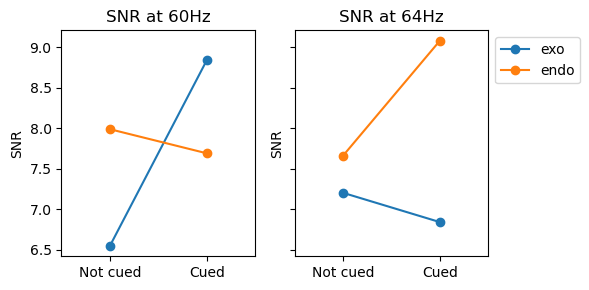

In [12]:
fig, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
ax[0].plot([0,1], [vals['60cued_tag == 64 & attention_type_block==0'], vals['60cued_tag == 60 & attention_type_block==0']], 'o-', label='exo')
ax[1].plot([0,1], [vals['64cued_tag == 60 & attention_type_block==0'], vals['64cued_tag == 64 & attention_type_block==0']], 'o-', label='exo')
ax[0].plot([0,1], [vals['60cued_tag == 64 & attention_type_block==1'], vals['60cued_tag == 60 & attention_type_block==1']], 'o-', label='endo')
ax[1].plot([0,1], [vals['64cued_tag == 60 & attention_type_block==1'], vals['64cued_tag == 64 & attention_type_block==1']], 'o-', label='endo')

ax[0].set_title('SNR at 60Hz')
ax[1].set_title('SNR at 64Hz')
ax[0].set_ylabel('SNR')
ax[1].set_ylabel('SNR')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_xlim(-.5, 1.5)
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [13]:
def ami(unattended, attended):
    return (attended-unattended)/(attended+unattended)
    
cueing_60_exo = ami(vals['60cued_tag == 64 & attention_type_block==0'], vals['60cued_tag == 60 & attention_type_block==0'])
cueing_64_exo = ami(vals['64cued_tag == 60 & attention_type_block==0'], vals['64cued_tag == 64 & attention_type_block==0'])
cueing_60_endo = ami(vals['60cued_tag == 64 & attention_type_block==1'], vals['60cued_tag == 60 & attention_type_block==1'])
cueing_64_endo = ami(vals['64cued_tag == 60 & attention_type_block==1'], vals['64cued_tag == 64 & attention_type_block==1'])

ami_all = np.stack([cueing_60_exo,cueing_64_exo,cueing_60_endo,cueing_64_endo])
np.save('files/B2_ami.npy', ami_all)

### Comparing coherence across cued conditions

In [ ]:
# time window from -0.2 sec to 1.25 sec relative to cue
tmin, tmax = -.5, 1.25

# Get inter-trial coherence with 60 and 64Hz by cued frequency 
freqs6064 = np.array([60, 64])

epochs_endo_cropped = epochs_endo['cued_tag == 64'].copy().crop(tmin, tmax)
channels = epochs.info['ch_names']
coherence_mat = np.zeros((len(channels), freqs.size, len(epochs_endo_cropped.times)))
for e, channel in enumerate(channels):
    for i, freq in enumerate(freqs6064):
        coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)
coherence_hilbert_endo_64 = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

epochs_endo_cropped = epochs_endo['cued_tag == 60'].copy().crop(tmin, tmax)
for e, channel in enumerate(channels):
    for i, freq in enumerate(freqs6064):
        coherence_mat[e,i,:] = coherence_kabir(epochs_endo_cropped, [channel], freq)
coherence_hilbert_endo_60 = mne.time_frequency.EpochsTFRArray(epochs_endo_cropped.info, np.array([coherence_mat]), epochs_endo_cropped.times, freqs)

epochs_exo_cropped = epochs_exo['cued_tag == 64'].copy().crop(tmin, tmax)
coherence_mat = np.zeros((len(channels), freqs.size, len(epochs_exo_cropped.times)))
for e, channel in enumerate(channels):
    for i, freq in enumerate(freqs6064):
        coherence_mat[e,i,:] = coherence_kabir(epochs_exo_cropped, [channel], freq)
coherence_hilbert_exo_64 = mne.time_frequency.EpochsTFRArray(epochs_exo_cropped.info, np.array([coherence_mat]), epochs_exo_cropped.times, freqs)

epochs_exo_cropped = epochs_exo['cued_tag == 60'].copy().crop(tmin, tmax)
for e, channel in enumerate(channels):
    for i, freq in enumerate(freqs6064):
        coherence_mat[e,i,:] = coherence_kabir(epochs_exo_cropped, [channel], freq)
coherence_hilbert_exo_60 = mne.time_frequency.EpochsTFRArray(epochs_exo_cropped.info, np.array([coherence_mat]), epochs_exo_cropped.times, freqs)

coherence = {}
coherence_64_arr, times_coh, freqs_idx = coherence_hilbert_endo_64.get_data(return_freqs = True, return_times = True)
coherence_60_arr = coherence_hilbert_endo_60.get_data()
coherence['with64_for64cued_endo'] = coherence_64_arr[0,best_electrodes_64_idx,1,:]
coherence['with60_for64cued_endo'] = coherence_64_arr[0,best_electrodes_60_idx,0,:]
coherence['with64_for60cued_endo'] = coherence_60_arr[0,best_electrodes_64_idx,1,:]
coherence['with60_for60cued_endo'] = coherence_60_arr[0,best_electrodes_60_idx,0,:]
coherence_64_arr, times_coh, freqs_idx = coherence_hilbert_exo_64.get_data(return_freqs = True, return_times = True)
coherence_60_arr = coherence_hilbert_exo_60.get_data()
coherence['with64_for64cued_exo'] = coherence_64_arr[0,best_electrodes_64_idx,1,:]
coherence['with60_for64cued_exo'] = coherence_64_arr[0,best_electrodes_60_idx,0,:]
coherence['with64_for60cued_exo'] = coherence_60_arr[0,best_electrodes_64_idx,1,:]
coherence['with60_for60cued_exo'] = coherence_60_arr[0,best_electrodes_60_idx,0,:]

In [ ]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,5))
ax[0,0].plot(times_coh, coherence['with60_for60cued_endo'].T - coherence['with60_for64cued_endo'].T, label = np.array(epochs.info['ch_names'])[best_electrodes_60_idx])
ax[0,0].set_ylabel('Coherence 60Hz')
ax[0,0].set_title('Endogeneous difference 60Hz cued-uncued')
ax[1,0].plot(times_coh, coherence['with64_for64cued_endo'].T - coherence['with64_for60cued_endo'].T, label = np.array(epochs.info['ch_names'])[best_electrodes_64_idx])
ax[1,0].set_ylabel('Coherence 64Hz')
ax[1,0].set_title('Endogeneous difference 64Hz cued-uncued')
ax[0,1].plot(times_coh, coherence['with60_for60cued_exo'].T - coherence['with60_for64cued_exo'].T, label = np.array(epochs.info['ch_names'])[best_electrodes_60_idx])
ax[0,1].set_title('Exogeneous difference 60Hz cued-uncued')
ax[1,1].plot(times_coh, coherence['with64_for64cued_exo'].T - coherence['with64_for60cued_exo'].T, label =  np.array(epochs.info['ch_names'])[best_electrodes_64_idx])
ax[1,1].set_title('Exogeneous difference 64Hz cued-uncued')


plt.legend(bbox_to_anchor=(1,1))
ax[1,0].set_xlabel('Time from cue (second)')
ax[1,1].set_xlabel('Time from cue (second)')
plt.show()


In [ ]:
# Export for group analysis, average over electrodes

def pd_coh(coherence_dic, cued, coh_with, condition, times):
    coherence = pd.DataFrame(coherence_dic[f'with{coh_with}_for{cued}cued_{condition}'])
    #First normalize electrodes, then average
    coherence = pd.DataFrame(coherence.apply(lambda x: (x - np.mean(x)) / np.std(x), axis=1).mean()).T
    coherence['cued'] = cued
    coherence['coh_with'] = coh_with
    coherence['condition'] = condition
    coherence = coherence.melt(id_vars=['cued','coh_with','condition'])
    coherence['time'] = times
    return coherence

coh64_cue64_endo = pd_coh(coherence, 64, 64, 'endo', times_coh)
coh64_cue60_endo = pd_coh(coherence, 60, 64, 'endo', times_coh)
coh60_cue64_endo = pd_coh(coherence, 64, 60, 'endo', times_coh)
coh60_cue60_endo = pd_coh(coherence, 60, 60, 'endo', times_coh)
coh64_cue64_exo = pd_coh(coherence, 64, 64, 'exo', times_coh)
coh64_cue60_exo = pd_coh(coherence, 60, 64, 'exo', times_coh)
coh60_cue64_exo = pd_coh(coherence, 64, 60, 'exo', times_coh)
coh60_cue60_exo = pd_coh(coherence, 60, 60, 'exo', times_coh)

ITcoh_B2 = pd.concat([coh60_cue60_endo, coh60_cue64_endo, coh64_cue60_endo, coh64_cue64_endo,
                     coh60_cue60_exo, coh60_cue64_exo, coh64_cue60_exo, coh64_cue64_exo])
ITcoh_B2.columns = ['cued', 'coh_with', 'condition', 'timepoint', 'ITcoherence', 'time']
ITcoh_B2.to_csv('files/ITcoh_B2.csv',index=False)

# 3 - Predict cued side with a classifier

In [ ]:
# Load eeg epochs again to use all channels
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epoch_good = [x for x,y in enumerate(epochs.drop_log) if len(y) == 0]
epochs.metadata = pd_info.iloc[epoch_good]

# Remove trials where a target occured
epochs = epochs['targets_binary == 0']

# Downsample for speed
epochs.resample(200).pick_types(eeg=True)

# Simplify metadata
epochs.metadata['flicker_sides'] = epochs.metadata['flicker_sides'].replace({0: 6064, 1: 6460})
epochs.metadata['cued_side'] = epochs.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'left')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'right'))
condition_2 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'right')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'left'))
epochs.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 64, np.nan))
epochs_endo = epochs['attention_type_block==1'].copy()
epochs_exo = epochs['attention_type_block==0'].copy()


In [ ]:
# time window from -0.8 sec to 0.8 sec relative to cue
tmin, tmax = -0.8, 0.8

# Get power with 60 and 64Hz by cued frequency for each trial
freqs6064 = np.array([60, 64])
power_64_endo = epochs_endo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=False, average=False
)

power_60_endo = epochs_endo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=False, average=False
)
power_64_exo = epochs_exo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=False, average=False
)

power_60_exo = epochs_exo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=False, average=False
)


power = {}
power_64_arr, times_pow, freqs_idx = power_64_endo.get_data(return_freqs = True, return_times = True)
power_60_arr = power_60_endo.get_data()

# Take the difference between 60 and 64
power['for64cued_endo'] =  power_64_arr[:, :, 0,:] - power_64_arr[:, :, 1,:]
power['for60cued_endo'] = power_60_arr[:, :, 0,:] - power_60_arr[:, :, 1,:]
power_64_arr, times_pow, freqs_idx = power_64_exo.get_data(return_freqs = True, return_times = True)
power_60_arr = power_60_exo.get_data()
power['for64cued_exo'] =  power_64_arr[:, :, 0,:] - power_64_arr[:, :, 1,:]
power['for60cued_exo'] = power_60_arr[:, :, 0,:] - power_60_arr[:, :, 1,:]

In [ ]:
def pd_pow(power_dic, cued, condition, times, channels):
    pd_power = []
    n_trials = power_dic[f'for{cued}cued_{condition}'].shape[0]
    for e, electrode in enumerate(channels):
        power = pd.DataFrame(power_dic[f'for{cued}cued_{condition}'][:,e,:])
        power['cued'] = cued
        power['condition'] = condition
        power['epochs'] = np.arange(n_trials)
        power['channel'] = electrode
        power = power.melt(id_vars=['epochs','cued','condition','channel'])
        power = power.drop(columns=['variable'])
        power['time'] = np.repeat(times,n_trials)
        pd_power.append(power)
    pd_power = pd.concat(pd_power)
    return pd_power

cue64_endo = pd_pow(power, 64, 'endo', times_pow, epochs.info['ch_names'])
cue60_endo = pd_pow(power, 60, 'endo', times_pow, epochs.info['ch_names'])
cue64_exo = pd_pow(power, 64, 'exo', times_pow, epochs.info['ch_names'])
cue60_exo = pd_pow(power, 60, 'exo', times_pow, epochs.info['ch_names'])

pd_power = pd.concat([cue64_endo, cue60_endo, cue64_exo, cue60_exo])
pd_power.columns = ['epochs','cued', 'condition', 'channel', 'power', 'times']
pd_power

In [ ]:
# Reshape to the same format as MNE data
pivoted_df = pd_power.pivot_table(values='power', index=['epochs', 'cued', 'condition'], columns=['channel', 'times'])
times = pd_power['times'].unique()

# Matrix with dimensions epochs X channel X times
power_matrix = pivoted_df.values.reshape(len( pivoted_df.index), len(pd_power['channel'].unique()), len(times))

# Create epochs and add metadata
epochs_pow = mne.EpochsArray(power_matrix, epochs.info, tmin=times.min())
epochs_pow.metadata = pd_power.groupby(['cued','condition','epochs']).power.mean().reset_index().loc[:,['cued', 'condition']]

## Training on the baseline

In [ ]:
# Data preparation for training and prediction periods
tmin_training, tmax_training = -.8, -.2
# Take some time after training for plotting purposes 
tmin_prediction, tmax_prediction = -.2, .8
target_period = model_training(epochs_pow, tmin_training, tmax_training, tmin_prediction, tmax_prediction)

In [ ]:
plt.plot(target_period[target_period.attention == 'exo'].time, target_period[target_period.attention == 'exo'].score)
plt.plot(target_period[target_period.attention == 'endo'].time, target_period[target_period.attention == 'endo'].score)

In [ ]:
target_period.to_csv('files/B2_baseline_pow.csv')

## Training on the attention window (target onset period)

In [ ]:
# Data preparation for training and prediction periods
tmin_training, tmax_training = 0.1, .8
# Take some time after training for plotting purposes 
tmin_prediction, tmax_prediction = -.2, .8
target_period = model_training(epochs_pow, tmin_training, tmax_training, tmin_prediction, tmax_prediction)

In [ ]:
plt.plot(target_period[target_period.attention == 'exo'].time, target_period[target_period.attention == 'exo'].score)
plt.plot(target_period[target_period.attention == 'endo'].time, target_period[target_period.attention == 'endo'].score)

In [ ]:
target_period.to_csv('files/B2_target_period_pow.csv')